## Predictive Model for Water Level of the Chattooga River

TODO: ADD Image of the model here

As a whitewater kayaker, I take many trips to the Chattooga River. The water level is determined by the amount of rainfall in the area. It is important to know the water level of the river before making the trip, because if the water level is too high or too low, the river is not safe to take trips out. The goal of this project is to create a predictive model for the water level of the Chattooga River. This model will be used to predict the water level of the river for the next 24 hours. This will allow for an exploration of how predictive models work, using research to solve a problem, and provide a useful tool for me.

## Outline

## Data Collection

Data collection consited of two parts, the water level and the percipitation data. 

#### Water Level

The first part was collecting data from the USGS site. The USGS website contained data only back to 2007, which is a limiting factor, but it is the best data available for the Chattooga River. The data would specfically be take from one site, Chattooga River Near Clayton, GA, since this is the one most often used by us kayakers. Data is in the form of a text file, listing data about water levels every 15 min.

#### Weather Data

The second part of the data is the weather data. Rabun county was used as it is the location of the gauge we are using for the Chattooga River. The data was in the form of a csv, and contained data from 2007 to 2023, and contains data about weather pulled every day. 

#### Outline

ADD in all of the stuff about pulling data from USGS site enitially, but the issue was it was daily. Then running into the issue that 15 minute updates only went back to 2014. Then, used weather undergrounds api to access data from ashiway station, which is the closest station to the gauge. This could cause issue but we will see

## Data Processing

TODO: add more about data processing

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132256 entries, 2007-10-05 01:00:00 to 2023-05-29 17:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    132256 non-null  float64
 1   water   132256 non-null  float64
dtypes: float64(2)
memory usage: 3.0 MB


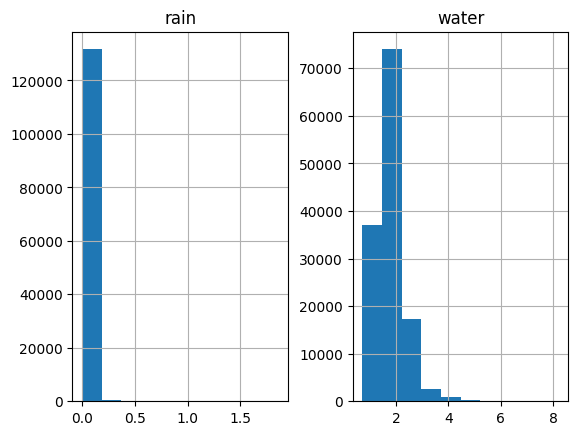

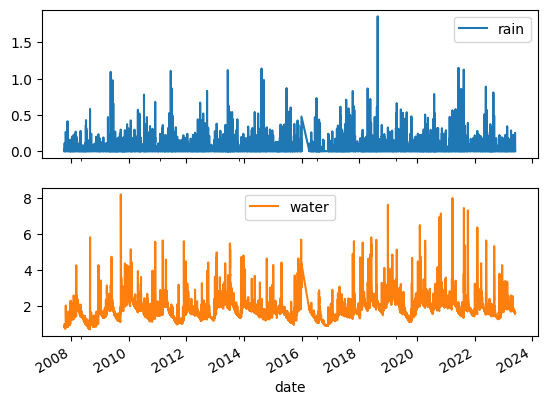

In [2]:
# This is the main file that will be used to run the project. Data pre-processing code can be seen in code/data-processing.py and code/scrape-precip-data.py
data = pd.read_csv('./data/combined_data.csv', parse_dates=['date'], index_col='date')

data.info()
data.hist()

# Plot the merged data (water level and precipitation)
data.plot(subplots=True)
plt.show()

In [93]:
from sklearn.model_selection import train_test_split

X = data.drop(['water'], axis=1)
y = data['water']

# COuld do this programatically but this is an 80/20 split
train_data = data.loc['2007-10-05 01:00:00':'2020-05-09 14:00:00']
test_data = data.loc['2020-05-09 14:00:00':]

train_X = train_data.drop(['water'], axis=1)
train_y = train_data['water']

test_X = test_data.drop(['water'], axis=1)
test_y = test_data['water']

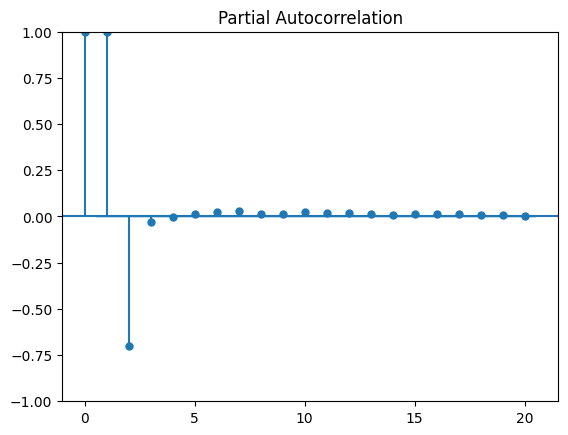

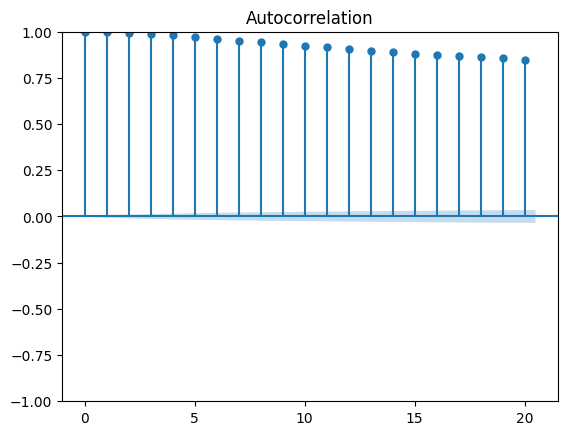

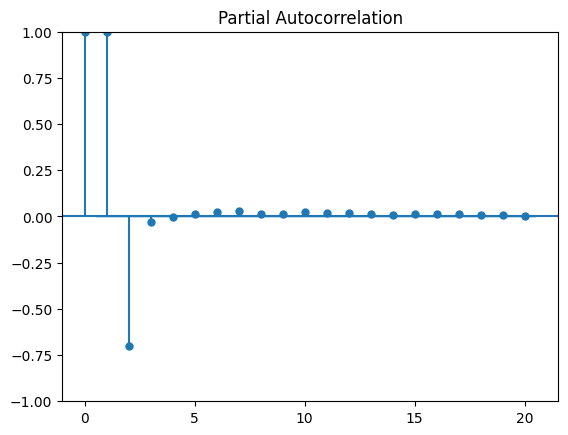

In [6]:
plot_acf(train_data['water'], lags=20)
plot_pacf(train_data['water'], lags=20)

### LSTM- First Breakthrough

TODO: 
    1. Add in the reasoning for using LSTM (papers etc)
    2. Clean up the code and remove all variable that are ...2 (this is the second iteration of the code)
    3. Optomize the values to try and get to at least 0.85 if possible

In [129]:
# Set up the LSTM model
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# Right now this means 10 days to me
sequence_length = 4

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['water'].values.reshape(-1, 1))
train_data2 = scaled_data[:int(0.8 * len(data))]
test_data2 = scaled_data[int(0.8 * len(data)):]

# Reshape data to be sequences of 10 days
def create_sequences(data, sequence_length):
    xs = []
    ys = []

    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

train_X, train_y = create_sequences(train_data2, sequence_length)
print(f'Training shape: {train_X.shape}')
print(f'Training label shape: {train_y.shape}')

model = Sequential()
model.add(LSTM(sequence_length, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

test_X2, test_y2 = create_sequences(test_data2, sequence_length)
model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X2, test_y2), verbose=2, shuffle=False)

Training shape: (105800, 4, 1)
Training label shape: (105800, 1)
Epoch 1/10
3307/3307 - 4s - loss: 3.4344e-04 - val_loss: 4.2631e-04 - 4s/epoch - 1ms/step
Epoch 2/10
3307/3307 - 3s - loss: 1.4691e-04 - val_loss: 2.2247e-04 - 3s/epoch - 1ms/step
Epoch 3/10
3307/3307 - 3s - loss: 1.0367e-04 - val_loss: 1.4344e-04 - 3s/epoch - 1ms/step
Epoch 4/10
3307/3307 - 3s - loss: 8.6936e-05 - val_loss: 1.2378e-04 - 3s/epoch - 1ms/step
Epoch 5/10
3307/3307 - 3s - loss: 7.5489e-05 - val_loss: 1.1479e-04 - 3s/epoch - 1ms/step
Epoch 6/10
3307/3307 - 3s - loss: 6.7143e-05 - val_loss: 9.8443e-05 - 3s/epoch - 1ms/step
Epoch 7/10
3307/3307 - 4s - loss: 6.2130e-05 - val_loss: 7.9455e-05 - 4s/epoch - 1ms/step
Epoch 8/10
3307/3307 - 3s - loss: 5.4654e-05 - val_loss: 6.9267e-05 - 3s/epoch - 1ms/step
Epoch 9/10
3307/3307 - 3s - loss: 4.8345e-05 - val_loss: 5.9168e-05 - 3s/epoch - 1ms/step
Epoch 10/10
3307/3307 - 3s - loss: 4.3123e-05 - val_loss: 5.1488e-05 - 3s/epoch - 1ms/step


In [130]:
predicted_values = model.predict(test_X2)
predicted_values = scaler.inverse_transform(predicted_values)

827/827 [==============================] - 0s 447us/step


R^2: 0.8719190385628771


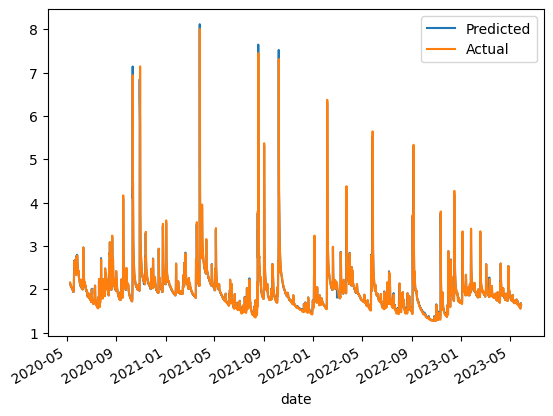

In [131]:
# Using drop() function to delete last 10 rows so that the sizes match
test_data2 = test_data.copy()
test_data2.drop(test_data.tail(sequence_length+2).index, inplace=True)

predictions_df = pd.DataFrame({'Predicted': predicted_values.flatten(), 'Actual': test_data2['water']})

predictions_df.plot()

# Calculate the R-squared value
print("R^2:", r2_score(test_data2['water'], predicted_values.flatten()))

### WIP- Everything below here is a work in progress

In [4]:
# Define the ARIMA model parameters
p = 1  # AR order
d = 1  # Integration order
q = 2  # MA order

# Create the ARIMA model
model = ARIMA(train_data['water'], order=(p, d, q))

# Fit the model to the training data, using the precipitation amount as an exogenous variable
model_fit = model.fit()

/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  water   No. Observations:               105803
Model:                 ARIMA(1, 1, 2)   Log Likelihood              242330.207
Date:                Thu, 22 Jun 2023   AIC                        -484652.414
Time:                        10:41:53   BIC                        -484614.137
Sample:                             0   HQIC                       -484640.827
                             - 105803                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7174      0.001    914.349      0.000       0.716       0.719
ma.L1         -0.0244      0.001    -31.431      0.000      -0.026      -0.023
ma.L2          0.0012      0.001      1.472      0.1

/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

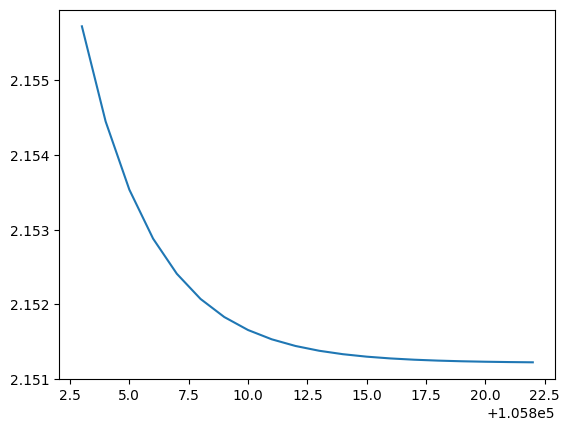

In [7]:
# Specify the start and end dates for prediction
start_date = test_data.index[0]
end_date = test_data.index[-1]

print(model_fit.summary())

# Generate predictions for the specified date range, usisng the precipitation amount as an exogenous variable
# predictions = model_fit.predict(start=start_date)

predictions = model_fit.forecast(20)

predictions

predictions.plot()

# mse = np.mean((predictions - test_data['water_level']) ** 2)

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

svm_model = SVR(kernel='rbf')

X_train = train_data['rain'].values.reshape(-1, 1)
y_train = train_data['water'].values

y_train

svm_model.fit(X_train, y_train)

X_test = test_data['rain'].values.reshape(-1, 1)
y_test = test_data['water'].values

y_pred = svm_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.3042227534315587
R-squared: -0.3315628092105727
